# Impact of 3.2 Beer in Kansas

In [32]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, Birch, DBSCAN, FeatureAgglomeration, KMeans, MiniBatchKMeans, MeanShift, SpectralClustering
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [78]:
%run ../cluster_GridSearch3.py

### Load Data

In [3]:
#Stores Data
Stores = pd.read_csv('KansasStoreDataV1.csv')
#Stores Classification data
StoresClass = pd.read_csv('NonLowPointStoresKansasV1.csv', dtype = str)

In [4]:
Stores.head()

,STORE_CD,L12M_TY_QTY,PREMISE_TYPE_DSC,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,BEER_FLG,...,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT
0,102440246,NaN,ON PREMISE,DINING,FAST CASUAL,MEXICAN,UNKNOWN,Y,N,Y,...,0.0625,0.0386,0.0208,0.0248,0.0614,0.0677,0.0667,0.0683,0.0446,0.0307
1,102137482,NaN,ON PREMISE,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,UNKNOWN,N,N,Y,...,0.0620,0.0401,0.0252,0.0262,0.0769,0.0611,0.0572,0.0651,0.0462,0.0367
2,101739463,NaN,ON PREMISE,RECREATION,GOLF/COUNTRY CLUB,OTHER,UNKNOWN,N,N,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,107507929,NaN,ON PREMISE,DINING,CASUAL DINING,ETHNIC,UNKNOWN,N,N,Y,...,0.0324,0.0225,0.0132,0.1070,0.0838,0.0494,0.0310,0.0362,0.0247,0.0199
4,103714966,NaN,ON PREMISE,DINING,CASUAL DINING,ASIAN,UNKNOWN,N,N,Y,...,0.0516,0.0299,0.0134,0.0235,0.0675,0.0774,0.0666,0.0552,0.0355,0.0212


#### Clean Data

In [5]:

#Remove Stores without Depletion data for the last year (NAs)
Stores = Stores.loc[Stores['L12M_TY_QTY'].notnull(),:]
print('Stores after removing stores with no depletion data ',len(Stores))

#Remove Stores with Negative Depletion data for the last year
Stores = Stores.loc[Stores['L12M_TY_QTY'] > 0,:] 
print('Stores after removing stores with negative ',len(Stores))

#Remove Stores without Demographic data (NAs)
Stores = Stores.loc[Stores['MALE_POP_5564_PCT'].notnull(),:]
print('Stores after removing stores with no demographic data ',len(Stores))

Stores = Stores.reset_index(drop=True)

#Change Y and N to 1 and 0
Stores['CHAIN_IND_FLG'] = Stores['CHAIN_IND_FLG']=='Y'
Stores['FRANCHISE_FLG'] = Stores['FRANCHISE_FLG']=='Y'
Stores['BEER_FLG'] = Stores['BEER_FLG']=='Y'
Stores['WINE_FLG'] = Stores['WINE_FLG']=='Y'
Stores['LIQUOR_FLG'] = Stores['LIQUOR_FLG']=='Y'
Stores['FINE_WINE_FLG'] = Stores['FINE_WINE_FLG']=='Y'

Stores['STORE_CD'] = Stores['STORE_CD'].astype(str)

Stores after removing stores with no depletion data  3098
Stores after removing stores with negative  2789
Stores after removing stores with no demographic data  2584


In [6]:
#Divide stores data into ON PREMISE and OFF PREMISE

StoresON = Stores[Stores.PREMISE_TYPE_DSC == 'ON PREMISE'].reset_index(drop=True)
StoresOFF = Stores[Stores.PREMISE_TYPE_DSC == 'OFF PREMISE'].reset_index(drop=True)


## ON PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [7]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [8]:
len(StoresON.columns)

43

In [9]:
for col in StoresON.columns:
    print(StoresON[col].describe())

count           627
unique          627
top       203887295
freq              1
Name: STORE_CD, dtype: object
count     627.000000
mean       83.964763
std       168.762676
min         0.750000
25%         7.500000
50%        26.000000
75%        99.541050
max      2891.249700
Name: L12M_TY_QTY, dtype: float64
count            627
unique             1
top       ON PREMISE
freq             627
Name: PREMISE_TYPE_DSC, dtype: object
count        627
unique         5
top       DINING
freq         411
Name: CHANNEL_DSC, dtype: object
count               627
unique               17
top       CASUAL DINING
freq                317
Name: SUBCHANNEL_DSC, dtype: object
count       627
unique       11
top       OTHER
freq        170
Name: FOOD_TYPE_GROUP_DSC, dtype: object
count                         627
unique                          3
top       TOP 50% ON/ TOP 20% OFF
freq                          327
Name: INDUSTRY_VOL_DSC, dtype: object
count       627
unique        2
top       False
freq  

In [10]:
#Remove Not Necessary Columns
del StoresON['PREMISE_TYPE_DSC'] #Unique
del StoresON['BEER_FLG'] # No Variance
del StoresON['FINE_WINE_FLG'] # No Variance
del StoresON['CHAIN_IND_FLG']
del StoresON['FRANCHISE_FLG']
del StoresON['INDUSTRY_VOL_DSC']

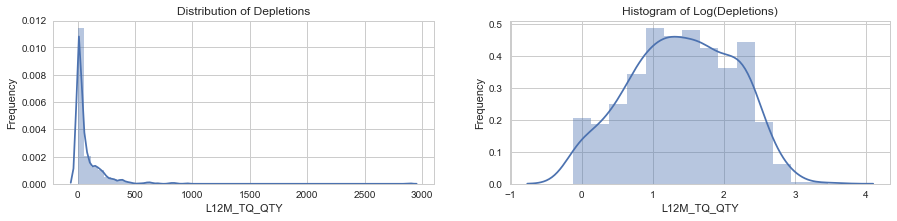

In [11]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresON['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresON['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [12]:
#Binarize function
def binarize(dataframe , column):
    dataframe = pd.concat([dataframe ,pd.get_dummies(dataframe[column] , prefix = ['B_'+c for c in column])] , axis = 1)
    return(dataframe)

In [13]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC',
       'FOOD_TYPE_GROUP_DSC', 'WINE_FLG', 'LIQUOR_FLG', 'WHITE_POP_PCT',
       'BLACK_POP_PCT', 'ASIAN_POP_PCT', 'HISP_POP_PCT',
       'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [14]:
#Get Dummies
#DummiesColumnsON = ['CHANNEL_DSC','INDUSTRY_VOL_DSC']
#StoresC_ON = binarize(StoresON, DummiesColumnsON)

#Normalize Depletions using Min-Max method
StoresC_ON = StoresON #Change if we add dummies again
scaler = MinMaxScaler() 
StoresC_ON['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresON['L12M_TY_QTY'].values.reshape(-1,1)) 


In [15]:
# prepare data to fit model
X_labels_ON = [c for c in StoresC_ON.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_ON = StoresC_ON.loc[:,X_labels_ON]

In [16]:
X_ON.head()

,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY
0,False,False,0.9009,0.0147,0.0065,0.0529,0.0100,0.0125,0.0304,0.0143,...,0.0415,0.0285,0.0251,0.0676,0.0624,0.0578,0.0648,0.0460,0.0433,0.001124
1,True,True,0.7495,0.0968,0.0631,0.0668,0.0133,0.0179,0.0356,0.0175,...,0.0405,0.0228,0.0268,0.0641,0.0622,0.0644,0.0676,0.0435,0.0318,0.012368
2,False,False,0.8433,0.0436,0.0080,0.0510,0.0101,0.0161,0.0248,0.0291,...,0.0519,0.0328,0.0224,0.0561,0.0551,0.0613,0.0715,0.0577,0.0472,0.001470
3,True,True,0.9453,0.0098,0.0035,0.0202,0.0043,0.0064,0.0095,0.0134,...,0.0435,0.0283,0.0223,0.0527,0.0614,0.0694,0.0696,0.0473,0.0435,0.000432
4,True,True,0.7901,0.0996,0.0231,0.0655,0.0116,0.0200,0.0339,0.0151,...,0.0414,0.0207,0.0230,0.0575,0.0688,0.0657,0.0663,0.0462,0.0314,0.040554


In [17]:
X_ON.columns

Index(['WINE_FLG', 'LIQUOR_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT',
       'ASIAN_POP_PCT', 'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT',
       'BI_CULTURAL_HISP_POP_PCT', 'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT',
       'INCOME_POP_L10_PCT', 'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT',
       'INCOME_POP_3040_PCT', 'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT',
       'INCOME_POP_75100_PCT', 'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT',
       'MALE_POP_2534_PCT', 'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT',
       'MALE_POP_5564_PCT', 'MALE_POP_6574_PCT', 'MALE_POP_75_PCT',
       'FEMALE_POP_2124_PCT', 'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT',
       'FEMALE_POP_4554_PCT', 'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT',
       'FEMALE_POP_75_PCT', 'NORM_L12M_TY_QTY'],
      dtype='object')

### Clustering

#### Choose number of Clusters and algorithm using Grid Search

In [29]:
model_param = {'KMeans':{'model':KMeans(),
                         'n_clusters':range(2,15,1),
                         'n_jobs':[-2]},
               'AffinityProp':{'model':AffinityPropagation(),
                              'damping':np.arange(0.5,0.9,0.1)},
               'MeanShift':{'model':MeanShift(),
                              'n_jobs':[-2]},
               'DBSCAN':{'model':DBSCAN(),
                         'eps':np.arange(0.2,0.9,0.1), 
                         'min_samples':range(5,200,20),
                         'n_jobs':[-2]}
              }

In [30]:
perf_metric = {'Silhouette':{'metric':'euclidean',
                             'random_state':1}}

In [31]:
#Cluster Grid Search
cluster_GridSearch(X_ON, model_param, perf_metric)

OPTIMAL MODEL
Model: DBSCAN
Parameters: {'eps': 0.30000000000000004, 'min_samples': 5, 'n_jobs': -2}
Clusters: 4
Silhouette: 0.7059619278080906


{'Model': 'DBSCAN',
 'Parameters': {'eps': 0.30000000000000004, 'min_samples': 5, 'n_jobs': -2},
 'Silhouette': 0.70596192780809064,
 'Trained_Model': DBSCAN(algorithm='auto', eps=0.30000000000000004, leaf_size=30,
     metric='euclidean', min_samples=5, n_jobs=-2, p=None)}

In [34]:
#Cluster the Data ON
cluster_model = cluster.DBSCAN(eps= 0.3, min_samples=5, n_jobs=-2).fit(X_ON)
labels = cluster_model.labels_

In [36]:
#Assign Cluster to Data
StoresON['CLUSTER'] = labels

In [37]:
StoresON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER
0,101914477,4.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,False,False,0.9009,0.0147,0.0065,...,0.0285,0.0251,0.0676,0.0624,0.0578,0.0648,0.0460,0.0433,0.001124,0
1,103707016,36.500,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,VARIED MENU,True,True,0.7495,0.0968,0.0631,...,0.0228,0.0268,0.0641,0.0622,0.0644,0.0676,0.0435,0.0318,0.012368,1
2,101930302,5.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,False,False,0.8433,0.0436,0.0080,...,0.0328,0.0224,0.0561,0.0551,0.0613,0.0715,0.0577,0.0472,0.001470,0
3,101943225,2.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,True,True,0.9453,0.0098,0.0035,...,0.0283,0.0223,0.0527,0.0614,0.0694,0.0696,0.0473,0.0435,0.000432,1
4,107487797,117.972,BAR/NIGHTCLUB,SPORTS BAR,AMERICAN,True,True,0.7901,0.0996,0.0231,...,0.0207,0.0230,0.0575,0.0688,0.0657,0.0663,0.0462,0.0314,0.040554,1


### Regression Analysis

In [38]:
#Merge Class with StoreON Data for regression
RegressionDataON = pd.merge(StoresON, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionDataON.loc[RegressionDataON['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [39]:
RegressionDataON.tail()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD,BEERTYPE
622,103997048,2.0000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,True,True,0.9619,0.0040,0.0058,...,0.0527,0.0524,0.0590,0.0916,0.0578,0.0713,0.000432,1,NaN,LowPoint
623,201737465,48.7222,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,True,True,0.8250,0.0652,0.0243,...,0.0713,0.0617,0.0590,0.0737,0.0592,0.0550,0.016597,1,201737465,NonLowPoint
624,107473689,27.0832,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,OTHER,True,True,0.6850,0.1013,0.0471,...,0.0738,0.0627,0.0578,0.0622,0.0417,0.0325,0.009110,1,107473689,NonLowPoint
625,301767732,21.0000,DINING,CASUAL DINING,VARIED MENU,True,True,0.8864,0.0542,0.0083,...,0.0667,0.0547,0.0599,0.0661,0.0473,0.0441,0.007006,1,NaN,LowPoint
626,107393252,5.0000,DINING,CASUAL DINING,VARIED MENU,False,False,0.8349,0.0032,0.0065,...,0.0447,0.0531,0.0623,0.0679,0.0491,0.0458,0.001470,0,NaN,LowPoint


In [40]:
len(RegressionDataON)

627

### Analysis of the Clusters

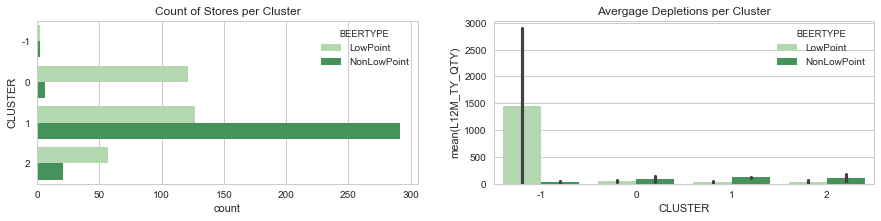

In [46]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "BEERTYPE", data=RegressionDataON, palette="Greens");

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="L12M_TY_QTY", hue="BEERTYPE", data=RegressionDataON, palette="Greens");

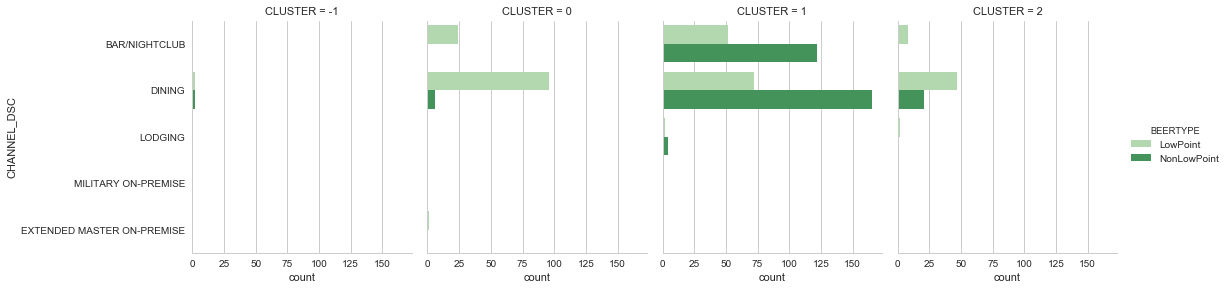

In [47]:
sns.factorplot(y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataON, kind="count", palette="Greens");

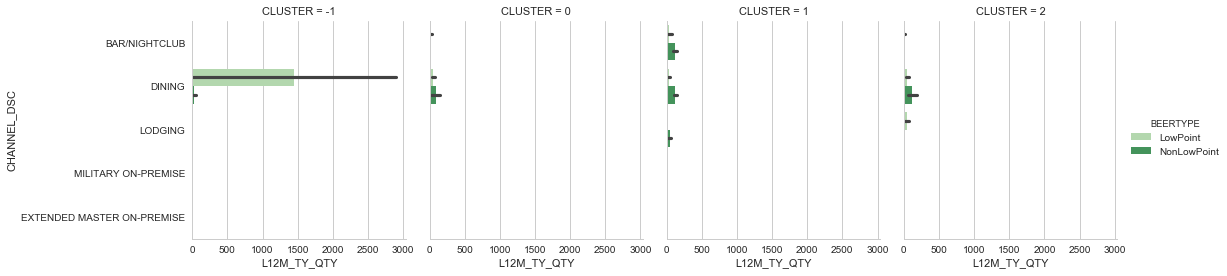

In [49]:
sns.factorplot(x='L12M_TY_QTY' ,y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataON, kind="bar", palette="Greens");

### Regression controlling for Cluster

In [41]:
#Regression ON Premise
modON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)*C(CLUSTER)', data=RegressionDataON)
print(modON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.210
Model:                             OLS   Adj. R-squared:                  0.201
Method:                  Least Squares   F-statistic:                     23.48
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           2.38e-28
Time:                         12:26:03   Log-Likelihood:                -1140.9
No. Observations:                  627   AIC:                             2298.
Df Residuals:                      619   BIC:                             2333.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [42]:
#Regression ON Premise
modON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE) + C(CLUSTER)', data=RegressionDataON)
print(modON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.200
Model:                             OLS   Adj. R-squared:                  0.194
Method:                  Least Squares   F-statistic:                     38.76
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           5.54e-29
Time:                         12:26:25   Log-Likelihood:                -1145.0
No. Observations:                  627   AIC:                             2300.
Df Residuals:                      622   BIC:                             2322.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [44]:
#Regression ON Premise
modON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataON)
print(modON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.197
Model:                             OLS   Adj. R-squared:                  0.196
Method:                  Least Squares   F-statistic:                     153.8
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           1.00e-31
Time:                         12:27:16   Log-Likelihood:                -1145.8
No. Observations:                  627   AIC:                             2296.
Df Residuals:                      625   BIC:                             2304.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

### Regression Based on Selected Cluster

#### Cluster 1

In [50]:
mod2ON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataON.loc[RegressionDataON["CLUSTER"]==1,:])
print(mod2ON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.219
Model:                             OLS   Adj. R-squared:                  0.218
Method:                  Least Squares   F-statistic:                     116.9
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           3.51e-24
Time:                         12:29:00   Log-Likelihood:                -750.99
No. Observations:                  418   AIC:                             1506.
Df Residuals:                      416   BIC:                             1514.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

## OFF PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [51]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [52]:
len(StoresOFF.columns)

43

In [53]:
for col in StoresOFF.columns:
    print(StoresOFF[col].describe())

count          1957
unique         1957
top       101881971
freq              1
Name: STORE_CD, dtype: object
count     1957.000000
mean       588.284411
std       1503.672089
min          1.000000
25%         23.000000
50%        124.000000
75%        515.250000
max      29712.999500
Name: L12M_TY_QTY, dtype: float64
count            1957
unique              1
top       OFF PREMISE
freq             1957
Name: PREMISE_TYPE_DSC, dtype: object
count                  1957
unique                    8
top       CONVENIENCE STORE
freq                    832
Name: CHANNEL_DSC, dtype: object
count                         1957
unique                          18
top       CONVENTIONAL CONVENIENCE
freq                           829
Name: SUBCHANNEL_DSC, dtype: object
count      1957
unique        1
top       OTHER
freq       1957
Name: FOOD_TYPE_GROUP_DSC, dtype: object
count                              1957
unique                                3
top       LOWEST 20% ON/ LOWEST 20% OFF
freq    

In [54]:
#Remove Not Necessary Columns
del StoresOFF['PREMISE_TYPE_DSC'] #Unique
del StoresOFF['FOOD_TYPE_GROUP_DSC'] #Unique
del StoresOFF['BEER_FLG'] # No Variance
del StoresOFF['FINE_WINE_FLG'] # No Variance
del StoresOFF['CHAIN_IND_FLG']
del StoresOFF['FRANCHISE_FLG']
del StoresOFF['INDUSTRY_VOL_DSC']

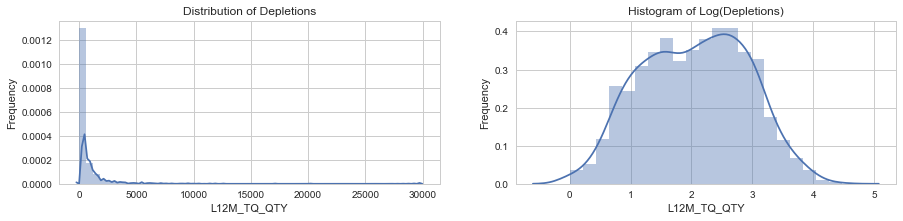

In [55]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresOFF['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresOFF['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [56]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC', 'WINE_FLG',
       'LIQUOR_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [57]:
#Get Dummies
#DummiesColumnsOFF = ['CHANNEL_DSC','INDUSTRY_VOL_DSC']
#StoresC_OFF = binarize(StoresOFF, DummiesColumnsOFF)

#Normalize Depletions using Min-Max method
StoresC_OFF = StoresOFF
scaler = MinMaxScaler() 
StoresC_OFF['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresOFF['L12M_TY_QTY'].values.reshape(-1,1)) 


In [58]:
# prepare data to fit model
X_labels_OFF = [c for c in StoresC_OFF.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_OFF = StoresC_OFF.loc[:,X_labels_OFF]

In [59]:
X_OFF.head()

,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,MOST_ACC_HISP_POP_PCT,OTHER_POP_PCT,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY
0,True,True,0.9437,0.0103,0.0081,0.0195,0.0041,0.0061,0.0093,0.0101,...,0.0527,0.0431,0.0231,0.0486,0.0518,0.0589,0.0753,0.0581,0.0576,0.002474
1,True,True,0.8233,0.0051,0.0065,0.1577,0.0274,0.0505,0.0799,0.0028,...,0.0475,0.0307,0.0202,0.0463,0.0540,0.0624,0.0649,0.0459,0.0381,0.010442
2,True,True,0.7785,0.0523,0.0719,0.0742,0.0117,0.0222,0.0402,0.0191,...,0.0339,0.0198,0.0638,0.0854,0.0565,0.0429,0.0522,0.0372,0.0258,0.020657
3,False,False,0.6504,0.1406,0.0332,0.1328,0.0238,0.0385,0.0706,0.0336,...,0.0252,0.0169,0.0491,0.0823,0.0514,0.0386,0.0413,0.0278,0.0231,0.001346
4,True,True,0.9537,0.0015,0.0010,0.0150,0.0029,0.0039,0.0082,0.0164,...,0.0633,0.0424,0.0199,0.0536,0.0463,0.0577,0.0840,0.0638,0.0577,0.004182


### Clustering

#### Choose number of Clusters and algorithm using Grid Search

In [60]:
#Cluster Grid Search
cluster_GridSearch(X_OFF, model_param, perf_metric)

OPTIMAL MODEL
Model: KMeans
Parameters: {'n_clusters': 2, 'n_jobs': -2}
Clusters: 14
Silhouette: 0.7847594290120072


{'Model': 'KMeans',
 'Parameters': {'n_clusters': 2, 'n_jobs': -2},
 'Silhouette': 0.78475942901200724,
 'Trained_Model': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=14, n_init=10, n_jobs=-2, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0)}

In [62]:
#Cluster the Data OFF
cluster_model = cluster.KMeans(n_clusters=2, random_state=1, n_jobs = -2).fit(X_OFF)
labels = cluster_model.labels_

In [63]:
#Assign Cluster to Data
StoresOFF['CLUSTER'] = labels

In [64]:
StoresOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,...,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER
0,107027552,74.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9437,0.0103,0.0081,0.0195,...,0.0431,0.0231,0.0486,0.0518,0.0589,0.0753,0.0581,0.0576,0.002474,1
1,201650423,311.2502,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.8233,0.0051,0.0065,0.1577,...,0.0307,0.0202,0.0463,0.0540,0.0624,0.0649,0.0459,0.0381,0.010442,1
2,100766228,614.7500,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.7785,0.0523,0.0719,0.0742,...,0.0198,0.0638,0.0854,0.0565,0.0429,0.0522,0.0372,0.0258,0.020657,1
3,100558459,41.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,False,False,0.6504,0.1406,0.0332,0.1328,...,0.0169,0.0491,0.0823,0.0514,0.0386,0.0413,0.0278,0.0231,0.001346,0
4,101633764,125.2500,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9537,0.0015,0.0010,0.0150,...,0.0424,0.0199,0.0536,0.0463,0.0577,0.0840,0.0638,0.0577,0.004182,1


### Regression Analysis

In [65]:
#Merge Class with StoreON Data for regression
RegressionDataOFF = pd.merge(StoresOFF, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionDataOFF.loc[RegressionDataOFF['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [66]:
RegressionDataOFF.tail()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,...,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD,BEERTYPE
1952,101403851,71.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9656,0.0017,0.0044,0.0156,...,0.0513,0.0495,0.0513,0.0818,0.0551,0.0584,0.002373,1,101403851,NonLowPoint
1953,101529400,3.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,False,False,0.6946,0.0194,0.0246,0.2413,...,0.0738,0.0577,0.0576,0.0618,0.0421,0.0407,0.000067,0,NaN,LowPoint
1954,107368998,1916.3331,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.5447,0.0333,0.0206,0.3880,...,0.0679,0.0597,0.0560,0.0585,0.0347,0.0318,0.064463,1,107368998,NonLowPoint
1955,100743019,53.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,False,False,0.6936,0.0268,0.0345,0.2224,...,0.0734,0.0562,0.0512,0.0522,0.0319,0.0245,0.001750,0,NaN,LowPoint
1956,201974199,115.9161,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9679,0.0005,0.0053,0.0139,...,0.0459,0.0421,0.0572,0.0790,0.0684,0.0729,0.003868,1,201974199,NonLowPoint


In [67]:
len(RegressionDataOFF)

1957

### Analysis of the Clusters

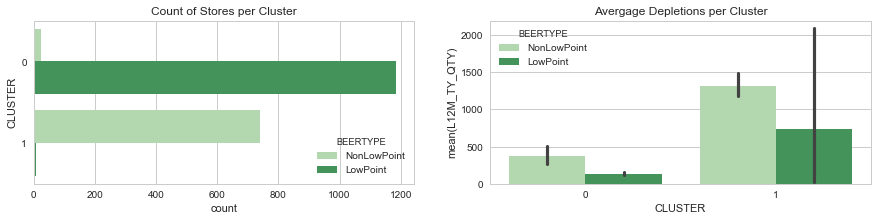

In [71]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "BEERTYPE", data=RegressionDataOFF, palette="Greens");

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="L12M_TY_QTY", hue="BEERTYPE", data=RegressionDataOFF, palette="Greens");

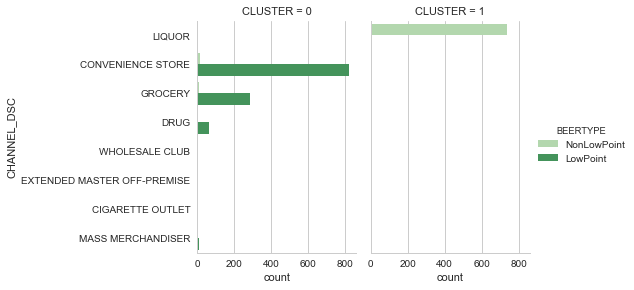

In [72]:
sns.factorplot(y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataOFF, kind="count", palette="Greens");

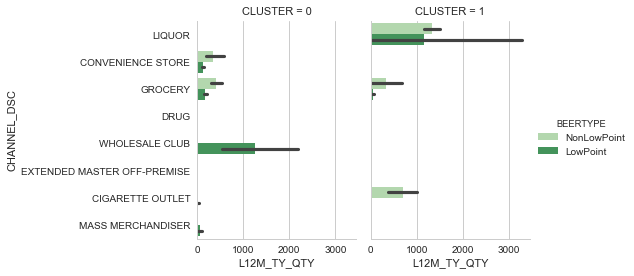

In [73]:
sns.factorplot(x='L12M_TY_QTY' ,y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataOFF, kind="bar", palette="Greens");

### Regression controlling for Cluster

In [68]:
#Regression ON Premise
modOFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE) + C(CLUSTER)', data=RegressionDataOFF)
print(modOFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.445
Model:                             OLS   Adj. R-squared:                  0.444
Method:                  Least Squares   F-statistic:                     783.3
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):          1.57e-250
Time:                         12:33:26   Log-Likelihood:                -3552.0
No. Observations:                 1957   AIC:                             7110.
Df Residuals:                     1954   BIC:                             7127.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [69]:
#Regression ON Premise
modOFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)*C(CLUSTER)', data=RegressionDataOFF)
print(modOFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.445
Model:                             OLS   Adj. R-squared:                  0.444
Method:                  Least Squares   F-statistic:                     522.3
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):          3.48e-249
Time:                         12:33:26   Log-Likelihood:                -3551.6
No. Observations:                 1957   AIC:                             7111.
Df Residuals:                     1953   BIC:                             7134.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [70]:
#Regression ON Premise
modOFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF)
print(modOFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.443
Model:                             OLS   Adj. R-squared:                  0.443
Method:                  Least Squares   F-statistic:                     1554.
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):          1.43e-250
Time:                         12:33:27   Log-Likelihood:                -3555.8
No. Observations:                 1957   AIC:                             7116.
Df Residuals:                     1955   BIC:                             7127.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

### Regression Based on Selected Cluster

#### Cluster 1

In [74]:
mod2OFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF.loc[RegressionDataOFF["CLUSTER"]==0,:])
print(mod2OFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.029
Model:                             OLS   Adj. R-squared:                  0.028
Method:                  Least Squares   F-statistic:                     35.96
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           2.66e-09
Time:                         12:33:29   Log-Likelihood:                -2259.8
No. Observations:                 1210   AIC:                             4524.
Df Residuals:                     1208   BIC:                             4534.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [75]:
mod2OFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF.loc[RegressionDataOFF["CLUSTER"]==1,:])
print(mod2OFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.033
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                     25.38
Date:                 Wed, 05 Jul 2017   Prob (F-statistic):           5.92e-07
Time:                         12:33:29   Log-Likelihood:                -1281.4
No. Observations:                  747   AIC:                             2567.
Df Residuals:                      745   BIC:                             2576.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 